# Loading in the libraries.

In [1]:
# Old libraries that we know and love.
import numpy as np
import matplotlib.pylab as py
import pandas as pa
%matplotlib inline

# Our new libraries.
from sklearn import cross_validation, linear_model, feature_selection, metrics
import mayavi.mlab as mlab

# Supervised Regression

## Linear Regression

In [2]:
# Read in the data using 
Xy = pa.read_csv('Advertising.csv')

In [3]:
# Normalize data
# We do this to make plotting and processing easier.  Many Sklearn functions do this
# for you behind the scenes, but we do it explicitly.
# Note, that this is a cousing of the physics idea of nondimensionalization.  Think
# about the case where TV was measured in millions, while Radio was measured in
# thousands.  One could imagine TV totally washing out the effect of Radio.
# In effect, after normalization, each predictor now stands on an "even footing".
#
# Is this always a good idea?
Xy = (Xy-Xy.min())/(Xy.max()-Xy.min())

In [4]:
# Since we will be plotting many times, we define a function.
def myPlot(reg,X_train,y_train,X_test,y_test,xPlot,yPlot,zPlot,size=10,scale_factor=0.05):
    mlab.clf()
    mlab.points3d(np.array(X_train)[:,0], 
                  np.array(X_train)[:,1], 
                  np.array(y_train)[:,0],
                  color=(1,0,0), scale_factor=scale_factor)
    mlab.points3d(np.array(X_test)[:,0], 
                  np.array(X_test)[:,1], 
                  np.array(y_test)[:,0],
                  color=(0,1,0), scale_factor=scale_factor)
    mlab.mesh(xPlot,yPlot,zPlot,color=(0,0,1))
    mlab.axes()
    mlab.show()
    

## Non-linear fitting

In [5]:
# Now we try non-linear fittng.  See notes for details.  
# Note that we add a new column which is a *non-linear* function
# of the original data!
XyNonlinear = Xy.copy()
XyNonlinear['TV*Radio'] = Xy['TV']*Xy['Radio']

# Select out our predictor columns and our response columns
X = XyNonlinear.ix[:,['TV','Radio','TV*Radio']]
y = XyNonlinear.ix[:,['Sales']]

# Select subsets for training and testing
X_train,X_test,y_train,y_test = cross_validation.train_test_split(X,
                                                                  y,
                                                                  test_size=0.8,
                                                                  random_state=123)

In [6]:
# Run the solver
reg = linear_model.LinearRegression(fit_intercept=True)
reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [7]:
# Create data for plotting
size = 10

xPlot,yPlot = np.meshgrid(np.linspace(0,1,size),
                          np.linspace(0,1,size))
zPlot = reg.predict(np.transpose(np.array([xPlot.flatten(),
                                           yPlot.flatten(),
                                           (xPlot*yPlot).flatten()])))
zPlot = zPlot.reshape([size,size])

In [8]:
myPlot(reg,X_train,y_train,X_test,y_test,xPlot,yPlot,zPlot)

In [9]:
# Use the metrics package to print our errors
print 'training error'
print metrics.mean_squared_error(y_train,reg.predict(X_train))
print 'testing error'
print metrics.mean_squared_error(y_test,reg.predict(X_test))

training error
0.000954956008276
testing error
0.00149444601649


### Back to the notes

## Too much of a good thing...

In [10]:
# What about adding many non-linear combinations!  See notes for details.

degree=5
XCrazy = np.zeros([Xy.shape[0],degree**2])

for i in range(degree):
    for j in range(degree):
        XCrazy[:,i*degree + j] = (Xy['TV']**i)*(Xy['Radio']**j)
        
# Select subsets for training and testing
X_train,X_test,y_train,y_test = cross_validation.train_test_split(XCrazy,
                                                                  y,
                                                                  test_size=0.8,
                                                                  random_state=123)

In [11]:
# Run the solver
regOver = linear_model.LinearRegression(fit_intercept=True)
regOver.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
print regOver.intercept_
print regOver.coef_

[-6.94708351]
[[    0.            60.55943865  -166.07190603   184.75679654
    -72.32883146    58.42979358  -484.12475426  1297.94802249 -1408.4926764
    538.88687256  -170.96380512  1414.03394465 -3717.84399447
   3955.89719878 -1483.95230998   216.58492539 -1787.88418158
   4651.20425424 -4892.06944771  1814.15721388  -100.38566969
    829.96108306 -2151.36644677  2254.46299271  -833.66782304]]


In [13]:
# Create data for plotting
size = 10

xPlot,yPlot = np.meshgrid(np.linspace(0,1,size),
                          np.linspace(0,1,size))

tmp = []
for i in range(degree):
    for j in range(degree):
        tmp.append( ( (xPlot**i)*(yPlot**j) ).flatten() )

zPlot = regOver.predict(np.transpose(np.array(tmp)))
zPlot = zPlot.reshape([size,size])

In [14]:
# Plot the data

# Select subsets for training and testing
X_train_plot,X_test_plot = cross_validation.train_test_split(Xy.ix[:,['TV','Radio']],
                                                             test_size=0.8,
                                                             random_state=123)

myPlot(reg,X_train_plot,y_train,X_test_plot,y_test,xPlot,yPlot,zPlot)

In [15]:
# Use the metrics package to print our errors
print 'training error'
print metrics.mean_squared_error(y_train,regOver.predict(X_train))
print 'testing error'
print metrics.mean_squared_error(y_test,regOver.predict(X_test))

training error
3.41438151098e-05
testing error
0.34846904251


### Back to the notes.

## Model selection!

In [16]:
# Fortunately, there is a *lot* that one can do to help.  It is possible to have
# many predictors but still get good answers.  See notes for details...
degree=5
XCrazy = np.zeros([Xy.shape[0],degree**2])

names = []
for i in range(degree):
    for j in range(degree):
        XCrazy[:,i*degree + j] = (Xy['TV']**i)*(Xy['Radio']**j)
        names.append('TV**%d*Radio**%d'%(i,j))

# Select subsets for training and testing
X_train,X_test,y_train,y_test = cross_validation.train_test_split(XCrazy,
                                                                  y,
                                                                  test_size=0.8,
                                                                  random_state=123)

In [18]:
# We can try None and 3 to see what we get.
selector = feature_selection.RFE(regOver,n_features_to_select=3)
selector.fit(X_train,y_train)

C:\Users\randy\AppData\Local\Enthought\Canopy\User\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  estimator_params=None, n_features_to_select=3, step=1, verbose=0)

In [19]:
# Print out the predictors we use.  These are the predictors selection by the RFE algorithm
# as the most important.
for i in range(len(names)):
    print names[i],
    print selector.get_support()[i]

TV**0*Radio**0 False
TV**0*Radio**1 False
TV**0*Radio**2 False
TV**0*Radio**3 False
TV**0*Radio**4 False
TV**1*Radio**0 False
TV**1*Radio**1 False
TV**1*Radio**2 False
TV**1*Radio**3 False
TV**1*Radio**4 False
TV**2*Radio**0 False
TV**2*Radio**1 True
TV**2*Radio**2 False
TV**2*Radio**3 False
TV**2*Radio**4 False
TV**3*Radio**0 False
TV**3*Radio**1 False
TV**3*Radio**2 False
TV**3*Radio**3 True
TV**3*Radio**4 True
TV**4*Radio**0 False
TV**4*Radio**1 False
TV**4*Radio**2 False
TV**4*Radio**3 False
TV**4*Radio**4 False


In [20]:
# Create data for plotting
size = 10

xPlot,yPlot = np.meshgrid(np.linspace(0,1,size),
                          np.linspace(0,1,size))

tmp = []
for i in range(degree):
    for j in range(degree):
        tmp.append( ( (xPlot**i)*(yPlot**j) ).flatten() )

zPlot = selector.predict(np.transpose(np.array(tmp)))
zPlot = zPlot.reshape([size,size])

In [21]:
# Plot the data

# Select subsets for training and testing
X_train_plot,X_test_plot = cross_validation.train_test_split(Xy.ix[:,['TV','Radio']],
                                                             test_size=0.8,
                                                             random_state=123)
myPlot(reg,X_train_plot,y_train,X_test_plot,y_test,xPlot,yPlot,zPlot)

In [100]:
# Use the metrics package to print our errors
print 'training error'
print metrics.mean_squared_error(y_train,selector.predict(X_train))
print 'testing error'
print metrics.mean_squared_error(y_test,selector.predict(X_test))

training error
0.00265007247837
testing error
0.00490752683194


### Back to the notes

## Ridge Regression

In [22]:
# Lasso regression is another method for doing feature selection.
# It is, by far, by favorite it is a close cousin of my personal
# research topic.  See notes for details...
degree=5
XCrazy = np.zeros([Xy.shape[0],degree**2])

names = []
for i in range(degree):
    for j in range(degree):
        XCrazy[:,i*degree + j] = (Xy['TV']**i)*(Xy['Radio']**j)
        names.append('TV**%d*Radio**%d'%(i,j))
                     
# Select subsets for training and testing
X_train,X_test,y_train,y_test = cross_validation.train_test_split(XCrazy,
                                                                  y,
                                                                  test_size=0.8,
                                                                  random_state=123)

In [23]:
# Run the solver
# alpha=0.1 is good
regRidge = linear_model.Ridge(alpha=0.1,fit_intercept=True,normalize=True)
regRidge.fit(X_train,y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

[ 0.22904718]
TV**0*Radio**0 0.0
TV**0*Radio**1 0.0419186960158
TV**0*Radio**2 0.00828593733156
TV**0*Radio**3 -0.00363860992963
TV**0*Radio**4 -0.00674246754464
TV**1*Radio**0 0.230793741584
TV**1*Radio**1 0.237505006993
TV**1*Radio**2 0.172627232599
TV**1*Radio**3 0.125826237921
TV**1*Radio**4 0.0902523246675
TV**2*Radio**0 0.0585495124821
TV**2*Radio**1 0.111769896265
TV**2*Radio**2 0.0708431433845
TV**2*Radio**3 0.0276071315276
TV**2*Radio**4 -0.0110985683495
TV**3*Radio**0 -0.0140667046249
TV**3*Radio**1 0.0395870656911
TV**3*Radio**2 0.00637385625144
TV**3*Radio**3 -0.0361918400991
TV**3*Radio**4 -0.0786018850233
TV**4*Radio**0 -0.0497228460804
TV**4*Radio**1 -0.000493493435317
TV**4*Radio**2 -0.028374220438
TV**4*Radio**3 -0.0685555882185
TV**4*Radio**4 -0.11133322195


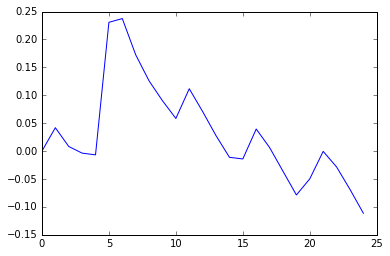

In [24]:
# Print out the predictors we use.  These betas with non-zero weights are those
# selected by the Lasso algorithm as being the most important.  What do you notice?
print regRidge.intercept_
for i in range(len(regRidge.coef_[0])):
    print names[i],regRidge.coef_[0][i]
py.plot(regRidge.coef_[0])

In [25]:
# Create data for plotting
size = 10

xPlot,yPlot = np.meshgrid(np.linspace(0,1,size),
                          np.linspace(0,1,size))

tmp = []
for i in range(degree):
    for j in range(degree):
        tmp.append( ( (xPlot**i)*(yPlot**j) ).flatten() )

zPlot = regRidge.predict(np.transpose(np.array(tmp)))
zPlot = zPlot.reshape([size,size])

In [26]:
# Plot the data

# Select subsets for training and testing
X_train_plot,X_test_plot = cross_validation.train_test_split(Xy.ix[:,['TV','Radio']],
                                                             test_size=0.8,
                                                             random_state=123)
myPlot(reg,X_train_plot,y_train,X_test_plot,y_test,xPlot,yPlot,zPlot)

In [106]:
# Use the metrics package to print our errors
print 'training error'
print metrics.mean_squared_error(y_train,regRidge.predict(X_train))
print 'testing error'
print metrics.mean_squared_error(y_test,regRidge.predict(X_test))

training error
0.000889778118984
testing error
0.0017501588195


### Back to the notes.

## Lasso!

In [28]:
# Lasso regression is another method for doing feature selection.
# It is, by far, by favorite it is a close cousin of my personal
# research topic.  See notes for details...
degree=5
XCrazy = np.zeros([Xy.shape[0],degree**2])

names = []
for i in range(degree):
    for j in range(degree):
        XCrazy[:,i*degree + j] = (Xy['TV']**i)*(Xy['Radio']**j)
        names.append('TV**%d*Radio**%d'%(i,j))
                     
# Select subsets for training and testing
X_train,X_test,y_train,y_test = cross_validation.train_test_split(XCrazy,
                                                                  y,
                                                                  test_size=0.8,
                                                                  random_state=123)

In [29]:
# Run the solver
regLasso = linear_model.Lasso(alpha=0.002,fit_intercept=True,normalize=True)
regLasso.fit(X_train,y_train)

Lasso(alpha=0.002, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

[ 0.27046738]
TV**0*Radio**0 0.0
TV**0*Radio**1 0.0
TV**0*Radio**2 0.0
TV**0*Radio**3 0.0
TV**0*Radio**4 0.0
TV**1*Radio**0 0.135662574951
TV**1*Radio**1 0.670730481986
TV**1*Radio**2 0.0
TV**1*Radio**3 0.0
TV**1*Radio**4 0.0
TV**2*Radio**0 0.0
TV**2*Radio**1 0.0
TV**2*Radio**2 0.0
TV**2*Radio**3 0.0
TV**2*Radio**4 0.0
TV**3*Radio**0 0.0
TV**3*Radio**1 0.0
TV**3*Radio**2 0.0
TV**3*Radio**3 0.0
TV**3*Radio**4 0.0
TV**4*Radio**0 0.0
TV**4*Radio**1 0.0
TV**4*Radio**2 0.0
TV**4*Radio**3 0.0
TV**4*Radio**4 0.0


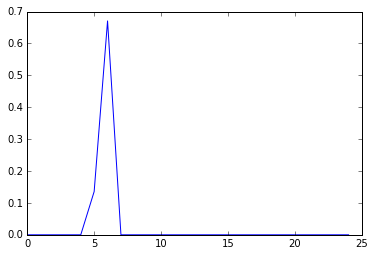

In [30]:
# Print out the predictors we use.  These betas with non-zero weights are those
# selected by the Lasso algorithm as being the most important.  What do you notice?
print regLasso.intercept_
for i in range(len(regLasso.coef_)):
    print names[i],regLasso.coef_[i]
py.plot(regLasso.coef_)

In [31]:
# Create data for plotting
size = 10

xPlot,yPlot = np.meshgrid(np.linspace(0,1,size),
                          np.linspace(0,1,size))

tmp = []
for i in range(degree):
    for j in range(degree):
        tmp.append( ( (xPlot**i)*(yPlot**j) ).flatten() )

zPlot = regLasso.predict(np.transpose(np.array(tmp)))
zPlot = zPlot.reshape([size,size])

In [32]:
# Plot the data

# Select subsets for training and testing
X_train_plot,X_test_plot = cross_validation.train_test_split(Xy.ix[:,['TV','Radio']],
                                                             test_size=0.8,
                                                             random_state=123)
myPlot(reg,X_train_plot,y_train,X_test_plot,y_test,xPlot,yPlot,zPlot)

In [112]:
# Use the metrics package to print our errors
print 'training error'
print metrics.mean_squared_error(y_train,regLasso.predict(X_train))
print 'testing error'
print metrics.mean_squared_error(y_test,regLasso.predict(X_test))

training error
0.00118345029043
testing error
0.002103671494


### Back to the notes.

In [27]:
2**20

1048576